# Predicción de calificaciones de películas utilizando árboles de decisión, XGBoost, SVC, KNN y MLP

Estudiantes:

*   René Quesada Carranza
*   Kevin Trejos Vargas
*   Kendall Tames Fernández
*   Adrián Hernández Young
*   Marcelo Solórzano Astorga



# Análisis Exploratorio de Datos (EDA, por sus siglas en inglés)

A continuación se ha de realizar un análisis exploratorio de datos, con la finalidad de mostrar las características esenciales de los datos a utilizar para el entrenamiento y validación de los distintos clasificadores a utilizar.



Dado a que hemos almacenado el dataset en Google Drive, es posible accesarlo mediante la siguiente biblioteca. Además, agregamos la posibilidad de ejutar el cuaderno localmente.

In [ ]:
import os

is_colab = 'google.colab' in str(get_ipython())

if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/My Drive/ml-100k')
else:
  data_path = os.getenv('dataPath')
  os.chdir(data_path)

Mounted at /content/drive


Se ignoran warnings que ensucian la salida.

In [ ]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

Una vez cambiado el entorno de ejecución a la carpeta donde se encuentran los datos, es posible leer los datos contenidos por u.data, y mostrar sus primeros elementos con la finalidad de tener una vista previa de los datos a los que nos enfrentamos.

In [ ]:
# Leer el dataset y almacenarlo en una variable con pandas
import pandas as pd

udata = pd.read_csv(
    "u.data",
    sep    = '\t',                                                              # Los datos están separados por tabs
    header = None,                                                              # u.data viene sin headers
    names  = ['user_id', 'item_id', 'rating', 'timestamp']                      # Nombres de las columnas
)
udata.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


A continuación se procede a extraer la información estadística correspondiente al conjunto de datos, con la finalidad de obtener una descripción de cada columna.

De esto es posible apreciar que se tiene un total de 100,000 datos, de los cuales, la columna de rating posee un total de 5 niveles, que van del 1 al 5.

In [ ]:
udata.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


Al obtener la información del conjunto de datos, es posible apreciar que no existen valores nulos, por lo cual se pueden tratar los datos directamente.

In [ ]:
udata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


Ahora bien, en la carpeta del dataset se cuentan con otros datos que podrían ser de gran ayuda, inclusive para ampliar las variables de entrada, a continuación se leen las mismas.

# u.info

En el caso de este archivo, contiene la cantidad de usuarios, items, y ratings que tiene el dataset.

In [ ]:
uinfo = pd.read_csv(
    "u.info",
    header = None,
    names  = ['info']
)
uinfo

,info
0,943 users
1,1682 items
2,100000 ratings


# u.genre

Contiene la lista de géneros contenidos el dataset, y un ID asignado a cada género.

In [ ]:
ugenre = pd.read_csv(
    "u.genre",
    sep = "|",
    header = None,
    names  = ['genre', 'genre_number']
)
ugenre

,genre,genre_number
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


# u.item

Contiene información sobre cada uno de los items (películas) que fueron evaluados por los distintos usuarios.

In [ ]:
uitem = pd.read_csv(
    "u.item",
    sep      = "|",
    header   = None,
    names    = ["movie_id", "movie_title", "release_date",
                "video_release_date", "IMDb_URL", "unknown",
                "Action", "Adventure", "Animation",
                "Children's", "Comedy", "Crime", "Documentary",
                "Drama", "Fantasy", "Film-Noir", "Horror",
                "Musical", "Mystery", "Romance", "Sci-Fi",
                "Thriller", "War", "Western"],
    encoding = 'latin-1'                                                        # Requerido por carácteres inválidos en UTF-8
)
uitem.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
uitem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

# u.user

Contiene información demográfica sobre cada uno de los usuarios, tal como edad, género, ocupación, y código postal.

In [ ]:
uuser = pd.read_csv(
    "u.user",
    sep = "|",
    header = None,
    names  = ['user_id', 'age', 'gender', 'occupation', 'zip code']
)
uuser.head()

,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
uuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [ ]:
uuser.describe()

,user_id,age
count,943.000000,943.000000
mean,472.000000,34.051962
std,272.364951,12.192740
min,1.000000,7.000000
25%,236.500000,25.000000
50%,472.000000,31.000000
75%,707.500000,43.000000
max,943.000000,73.000000


# Exploración de los datos
Una vez verificada la integridad de los datos, procedemos con la exploración de los datos.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

##Distribución de los ratings

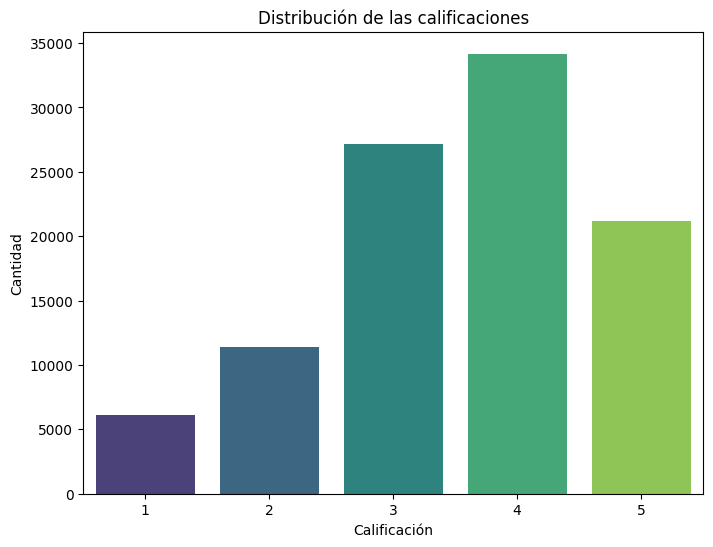

In [ ]:
# Gráfico de la distribución de las calificaiones
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=udata, palette='viridis')
plt.title('Distribución de las calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Cantidad')
plt.show()

##Distribución de la cantidad de calificaciones por usuario

Identificar la distribución de la cantidad de calificaciones por usuario es importante para saber si existen usuarios con pocas calificaciones, lo que nos podría estar generando ruido.

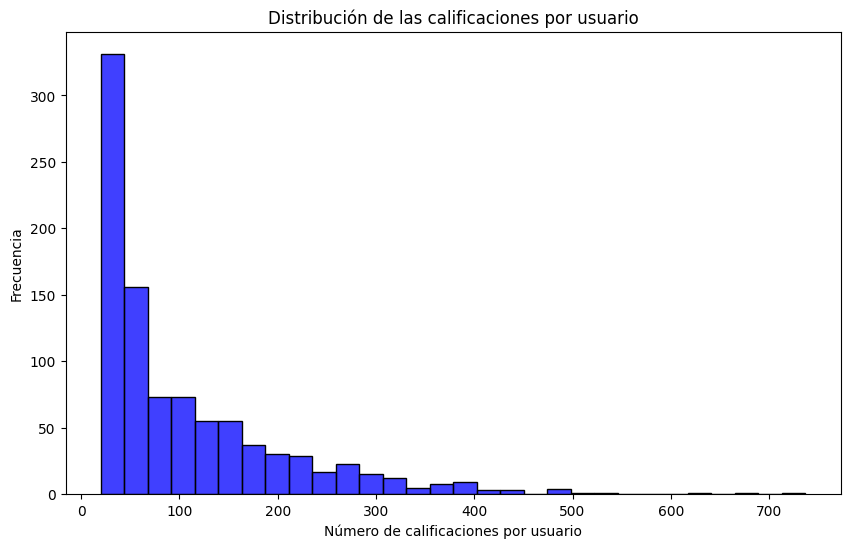

In [ ]:
# Calcular el número de calificaciones por usuario
user_ratings_count = udata.groupby('user_id').size()

# Gráfico del número de calificaciones por usuario
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count, bins=30, color='blue')
plt.title('Distribución de las calificaciones por usuario')
plt.xlabel('Número de calificaciones por usuario')
plt.ylabel('Frecuencia')
plt.show()

##Número de calificaciones por usuario

Identificar usuarios activos permite identificar qué usuarios son los más activos y cuáles son los menos activos en el sistema. Los usuarios que dan muchas calificaciones pueden tener un impacto significativo en los modelos de recomendación, ya que proporcionan más información.

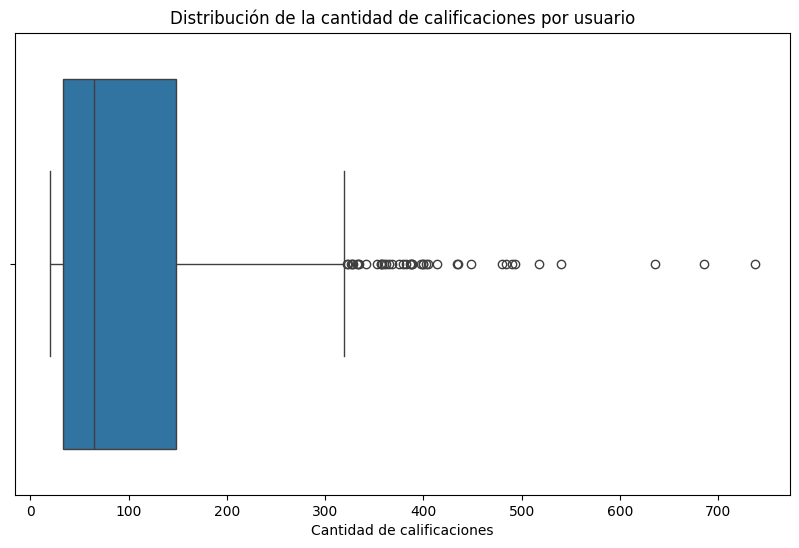

In [ ]:
ratings_per_user = udata.groupby('user_id').size()

plt.figure(figsize=(10, 6))
sns.boxplot(x=ratings_per_user)
plt.title('Distribución de la cantidad de calificaciones por usuario')
plt.xlabel('Cantidad de calificaciones')
plt.show()

##Número de Calificaciones por Película

Identificar películas populares permite identificar cuáles son las películas más populares o más vistas, es decir, las que han recibido más calificaciones. Estas películas pueden ser cruciales en los sistemas de recomendación y análisis de tendencias.

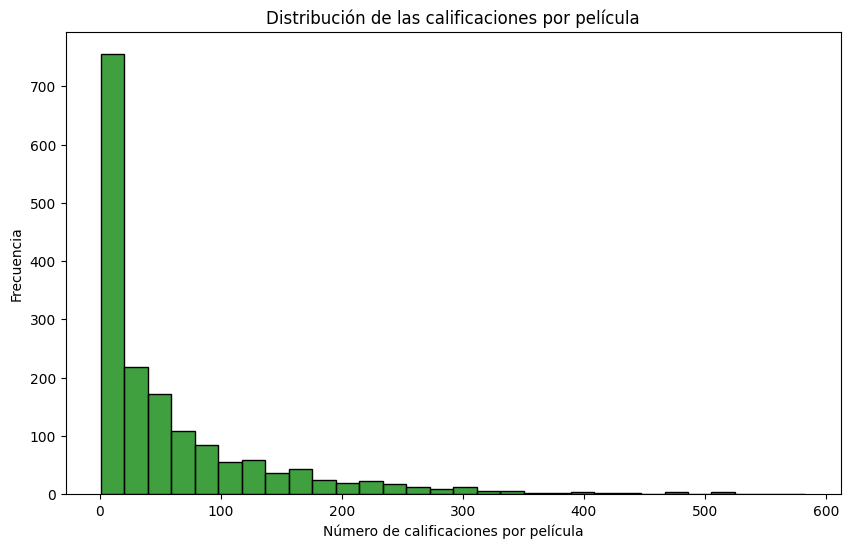

In [ ]:
# Calcular el número de calificaciones por película
movie_ratings_count = udata.groupby('item_id').size()

# Gráfico del número de calificaciones por película
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings_count, bins=30, color='green')
plt.title('Distribución de las calificaciones por película')
plt.xlabel('Número de calificaciones por película')
plt.ylabel('Frecuencia')
plt.show()


##Géneros más calificados

Analizar los géneros más valorados ayuda a entender mejor las preferencias los usuarios

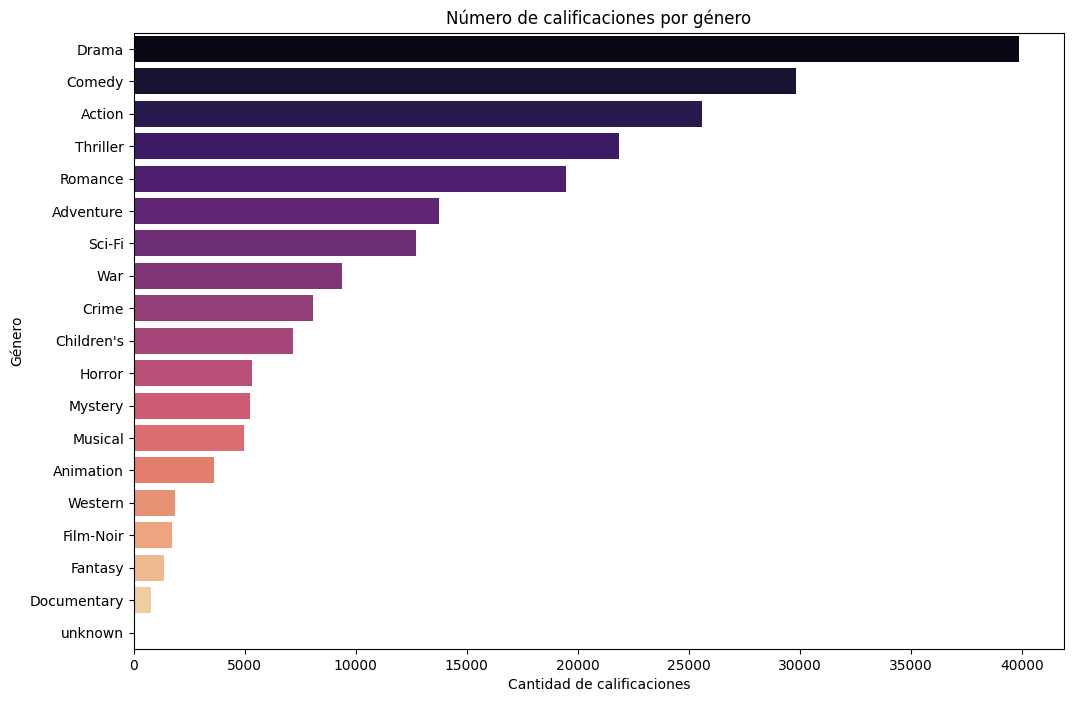

In [ ]:
merged_data = pd.merge(udata, uitem, left_on='item_id', right_on='movie_id')

# Calcular el número de calificaciones por género
genre_ratings_count = merged_data.iloc[:, -19:].sum().sort_values(ascending=False)

# Gráfico del número de calificaciones por género
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_ratings_count.values, y=genre_ratings_count.index, palette='magma')
plt.title('Número de calificaciones por género')
plt.xlabel('Cantidad de calificaciones')
plt.ylabel('Género')
plt.show()

##Promedio de calificaciones por usuario

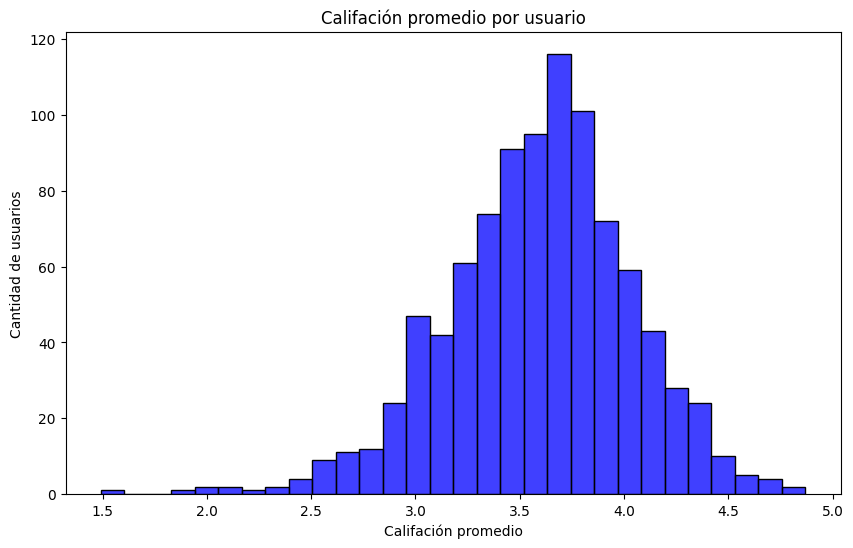

In [ ]:
average_ratings_per_user = udata.groupby('user_id')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_ratings_per_user, bins=30, color='blue')
plt.title('Califación promedio por usuario')
plt.xlabel('Califación promedio')
plt.ylabel('Cantidad de usuarios')
plt.show()

##Promedio de calificaciones por película

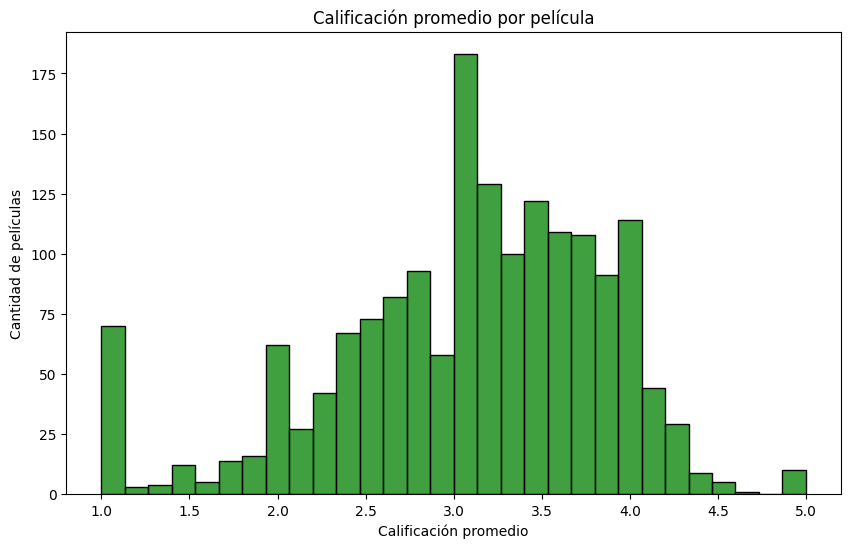

In [ ]:
average_ratings_per_item = udata.groupby('item_id')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_ratings_per_item, bins=30, color='green')
plt.title('Calificación promedio por película')
plt.xlabel('Calificación promedio')
plt.ylabel('Cantidad de películas')
plt.show()

# Preparando el dataset para la creación del árbol

Recordar primero cuales variables tenemos disponibles:

**uinfo**: Información general de los datos.

**udata**:  lista de calificaciones con el id del usuario, item_id, rating  y timestamp.
```
user_id	item_id	rating	timestamp
0	196	242	3	881250949
1	186	302	3	891717742
2	22	377	1	878887116
3	244	51	2	880606923
4	166	346	1	886397596
```

**ugenre**: lista de generos.

```
genre	genre_number
0	unknown	0
1	Action	1
2	Adventure	2
3	Animation	3
4	Children's	4
5	Comedy	5
6	Crime	6
7	Documentary	7
8	Drama	8
9	Fantasy	9
10	Film-Noir	10
11	Horror	11
12	Musical	12
13	Mystery	13
14	Romance	14
15	Sci-Fi	15
16	Thriller	16
17	War	17
18	Western	18
```
**uitem**: lista de fichas de películas. Un mismo cortometraje puede ser clasificado dentro de uno o más géneros, por lo cual además de la información general tendremos una columna para cada categoría.
```
    'movie_id',
    'movie_title',
    'release_date',
    'video_release_date',
    'IMDb_URL',
    'unknown',
    'Action',
    'Adventure',
    'Animation',
    "Children's",
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
```
**uuser**: lista de usuarios. Alberga información asociada al perfil del usuario.
```
 user_id	age	gender	occupation	zip code
0	1	24	M	technician	85711
1	2	53	F	other	94043
2	3	23	M	writer	32067
3	4	24	M	technician	43537
4	5	33	F	other	15213
```
Vamos a incluir del dataset la lista de u.occupation que contiene la lista de ocupaciones de los usuarios, esto nos ayudara a codificar las ocupaciones en un valor numérico.

**uoccupation**: lista de ocupaciones.
```
  occupation
0	administrator
1	artist
2	doctor
3	educator
4	engineer
```

In [ ]:
uoccupation = pd.read_csv(
    "u.occupation",
    header = None,
    names  = ['occupation']
)

uoccupation.head()

,occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer


In [ ]:
import numpy as np

# Barras para los datos null
import missingno as msno

# librerias de sklearn para el arbol
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# librerias de sklearn para las metricas
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

Lo primero que vamos a hacer es cargar la lista de ocupaciones y luego vamos a juntar todo

In [ ]:
# Combinando los datos de usuarios en la lista udata
user_data_merge = pd.merge(udata, uuser, on = 'user_id')
# ahora agregamos la información de las peliculas
all_merge_data = pd.merge(user_data_merge, uitem, left_on='item_id', right_on= 'movie_id')

all_merge_data.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip code,movie_id,movie_title,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  int64  
 1   item_id             100000 non-null  int64  
 2   rating              100000 non-null  int64  
 3   timestamp           100000 non-null  int64  
 4   age                 100000 non-null  int64  
 5   gender              100000 non-null  object 
 6   occupation          100000 non-null  object 
 7   zip code            100000 non-null  object 
 8   movie_id            100000 non-null  int64  
 9   movie_title         100000 non-null  object 
 10  release_date        99991 non-null   object 
 11  video_release_date  0 non-null       float64
 12  IMDb_URL            99987 non-null   object 
 13  unknown             100000 non-null  int64  
 14  Action              100000 non-null  int64  
 15  Adventure           100000 non-null

<Axes: >

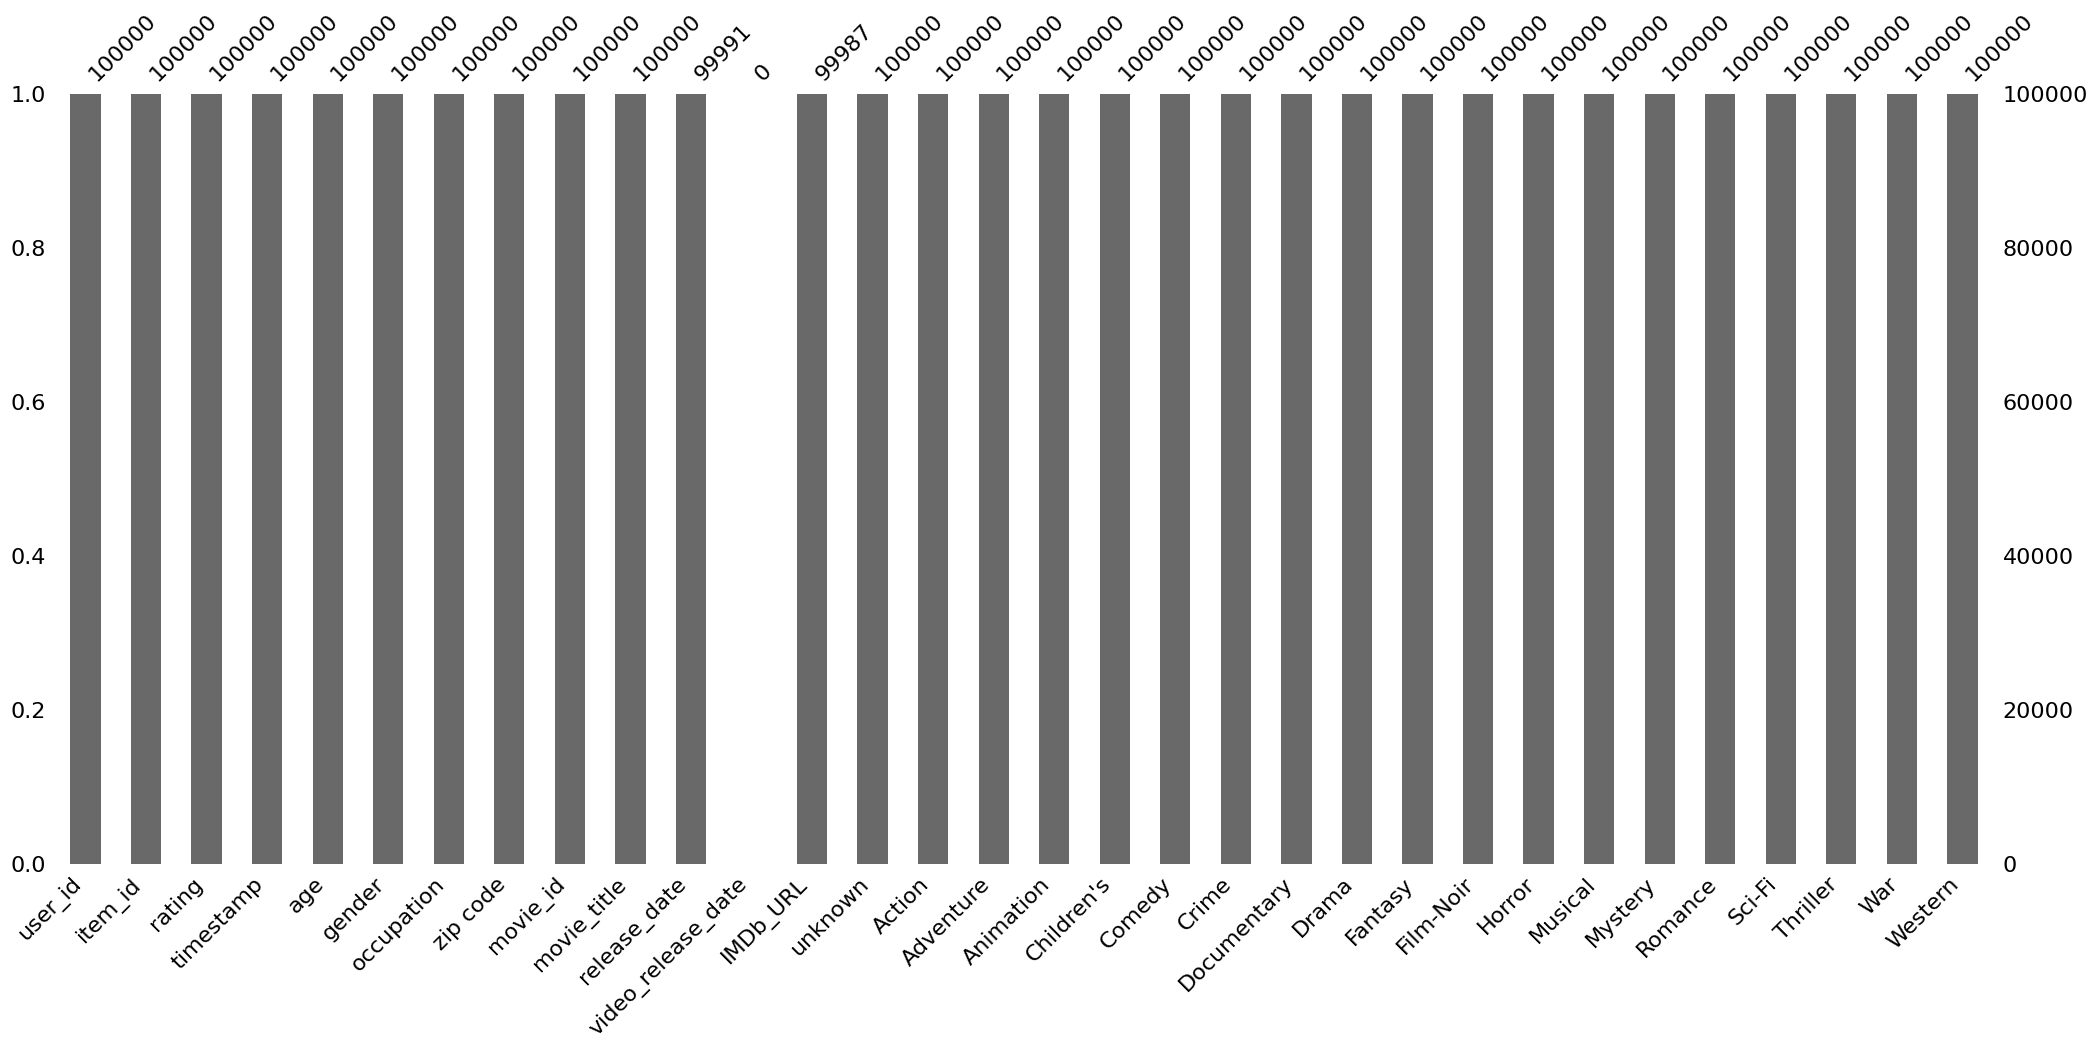

In [ ]:
all_merge_data.info()
# Ver las barras de valores vacios
msno.bar(all_merge_data)

Vemos que hay valores nulos pero tambien hay valores que no son de tipo INT por lo que primero tenemos que filtrar unos valores y eliminar las columnas que estan completamente vacias como el de video_release_date.

El primer paso es convertir los valores que no son enteros a un número, por ejemplo la fecha.

Hay muchas formas de convertir las fechas para un algoritmo uno de ellos es usar una fecha de referencia, es común usar la menor fecha en el dataset, sin embargo al tratarse de la fecha de salida de una pelicula vamos a usar como referencia la fecha de la primer pelicula que fue el 01-Nov-1895.

Ademas otros valores como el genero se pueden convertir en booleanos.

Otro punto importante es el de usar la lista de ocupaciones para codificar nuestra columna de ocupacion.

In [ ]:
# Definimos una constante de fecha de referencia
REFERENCE_DATE = pd.to_datetime('01-Nov-1895', format='%d-%b-%Y')

# Convertimos el formato de la fecha de release date a un tipo date time
all_merge_data['release_date'] = pd.to_datetime(all_merge_data['release_date'], format='%d-%b-%Y')

# Calcularmos la diferencia en dias de la fecha de cada una de las peliculas con respecto a la fecha referencia
all_merge_data['release_date_integer'] = (all_merge_data['release_date'] - REFERENCE_DATE).dt.days

# Ahora convertimos la columna de genero en una columna booleana
all_merge_data = pd.get_dummies(all_merge_data, columns=['gender'], drop_first=True)

# codificamos la columna de ocupaciones con la lista que tenemos de uoccupation
# usamos la posicion de la ocupacion en el dataset como numero para codificar
all_merge_data["occupation"] = all_merge_data["occupation"].apply(lambda x: uoccupation[uoccupation["occupation"] == x].index[0])

# Finalmente eliminamos las columnas que no ocupamos
all_merge_data.drop(columns=['release_date'], inplace=True)
all_merge_data.drop(columns=['video_release_date'], inplace=True)

all_merge_data.head()

,user_id,item_id,rating,timestamp,age,occupation,zip code,movie_id,movie_title,IMDb_URL,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_date_integer,gender_M
0,196,242,3,881250949,49,20,55105,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
1,305,242,5,886307828,23,14,94086,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
2,6,242,4,883268170,42,6,98101,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
3,234,242,4,891033261,60,15,94702,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
4,63,242,3,875747190,31,11,75240,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               100000 non-null  int64  
 1   item_id               100000 non-null  int64  
 2   rating                100000 non-null  int64  
 3   timestamp             100000 non-null  int64  
 4   age                   100000 non-null  int64  
 5   occupation            100000 non-null  int64  
 6   zip code              100000 non-null  object 
 7   movie_id              100000 non-null  int64  
 8   movie_title           100000 non-null  object 
 9   IMDb_URL              99987 non-null   object 
 10  unknown               100000 non-null  int64  
 11  Action                100000 non-null  int64  
 12  Adventure             100000 non-null  int64  
 13  Animation             100000 non-null  int64  
 14  Children's            100000 non-null  int64  
 15  C

<Axes: >

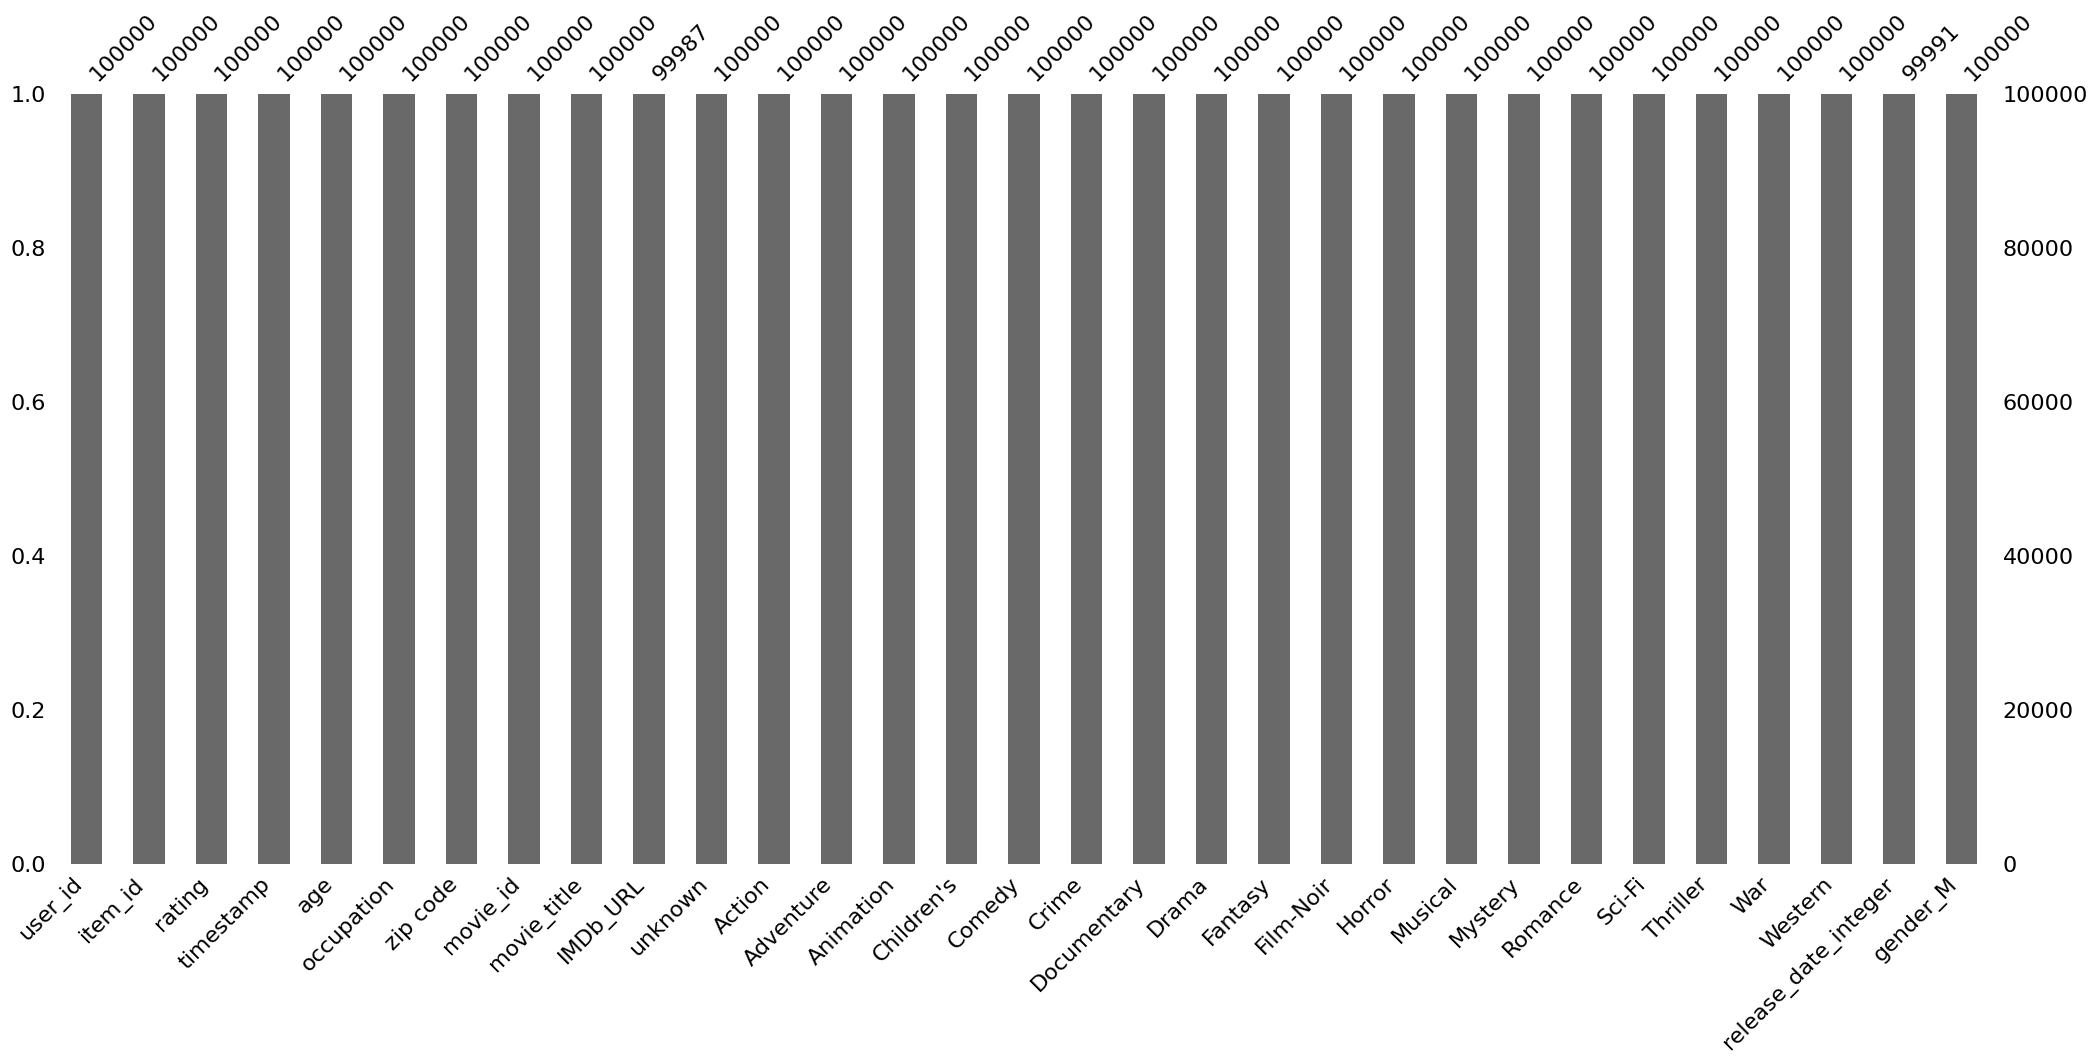

In [ ]:
all_merge_data.info()
# Ver las barras de valores vacios
msno.bar(all_merge_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               100000 non-null  int64  
 1   item_id               100000 non-null  int64  
 2   rating                100000 non-null  int64  
 3   timestamp             100000 non-null  int64  
 4   age                   100000 non-null  int64  
 5   occupation            100000 non-null  int64  
 6   zip code              100000 non-null  object 
 7   movie_id              100000 non-null  int64  
 8   movie_title           100000 non-null  object 
 9   IMDb_URL              100000 non-null  object 
 10  unknown               100000 non-null  int64  
 11  Action                100000 non-null  int64  
 12  Adventure             100000 non-null  int64  
 13  Animation             100000 non-null  int64  
 14  Children's            100000 non-null  int64  
 15  C

<Axes: >

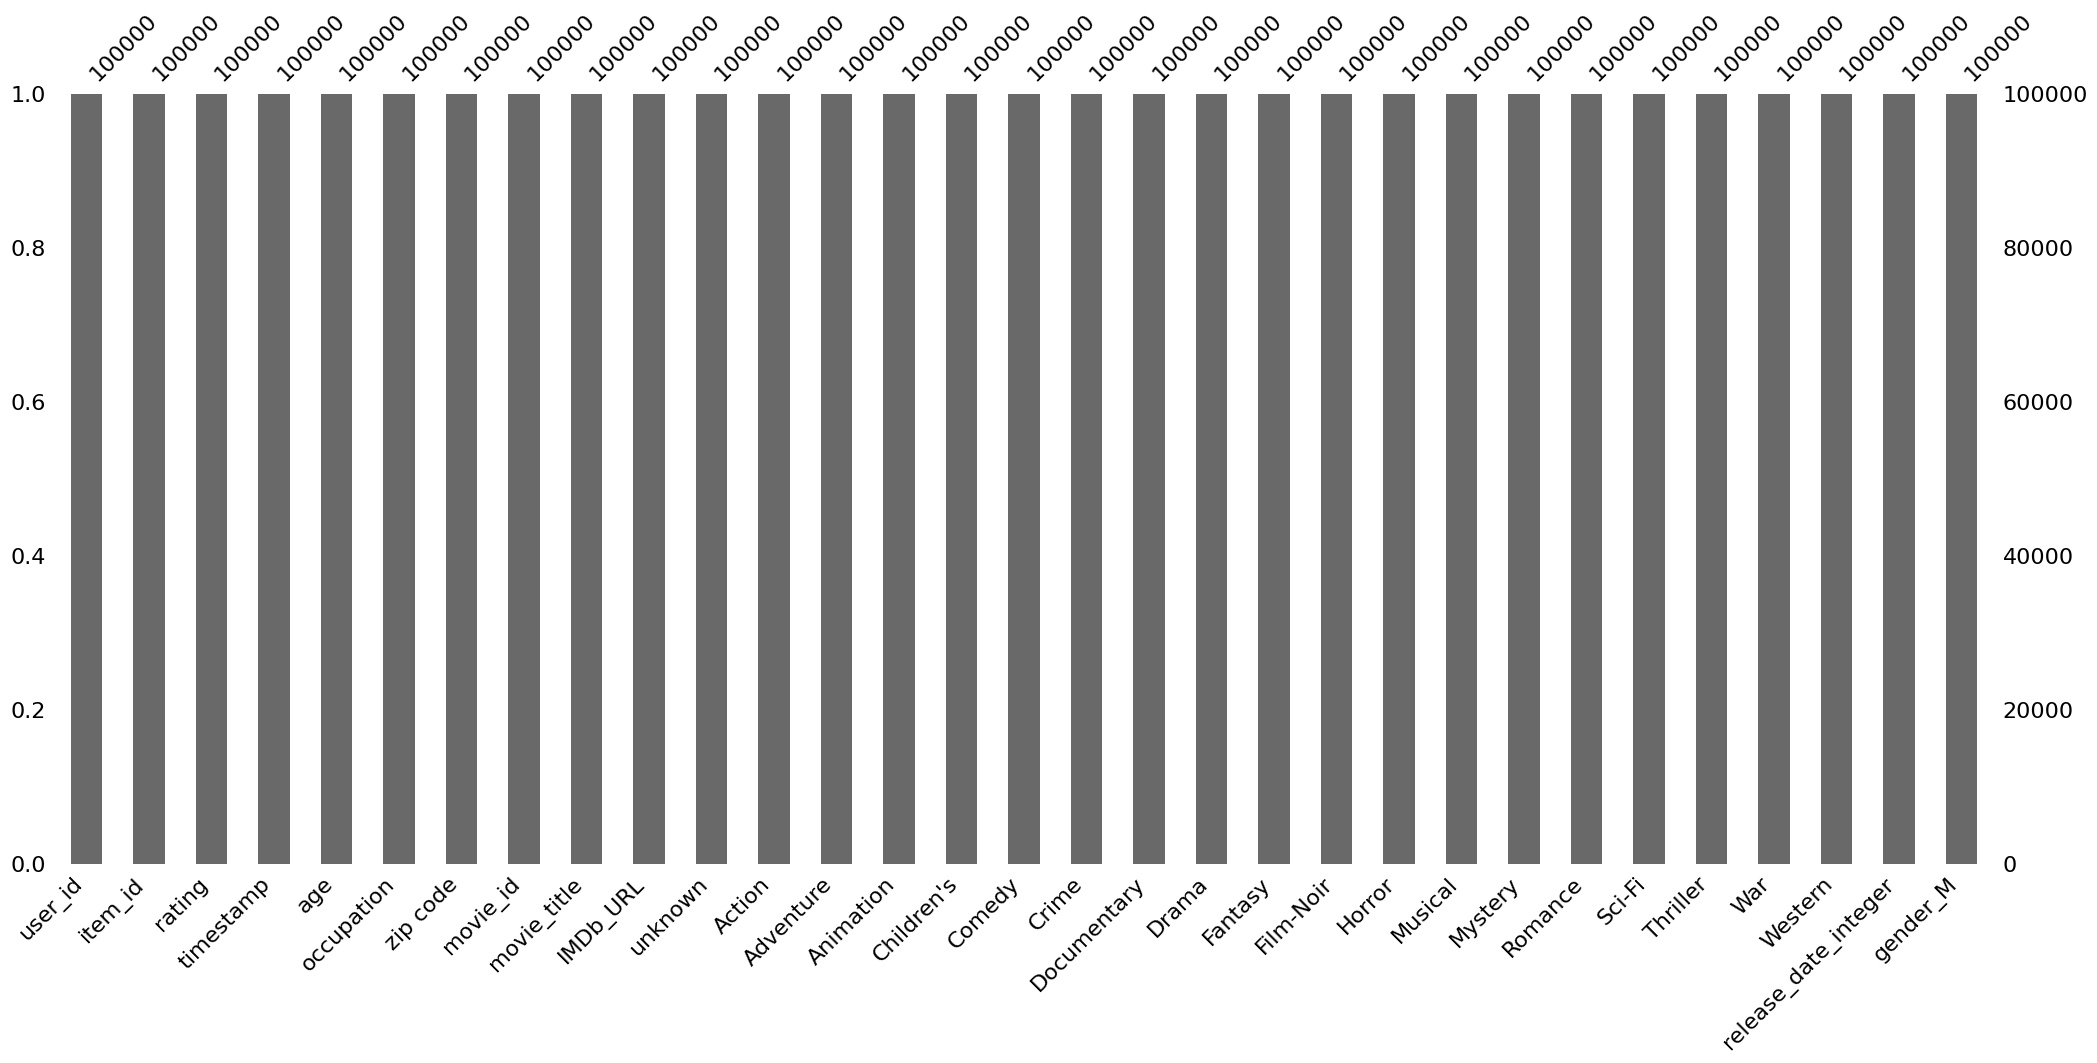

In [ ]:
# Se obtiene la media de la columna release_date_integer
mean_value = all_merge_data['release_date_integer'].mean()

# Se reemplaza los nulos con el valor de la media
all_merge_data['release_date_integer'].fillna(value=mean_value, inplace=True)

# como aun nos quedan algunas columnas on valores nulos vamos a llenarlos
all_merge_data.fillna(method='ffill', inplace=True)

# resultado final
all_merge_data.info()
# Ver las barras de valores vacios
msno.bar(all_merge_data)


In [ ]:
# lista de features
feature_list = all_merge_data.drop(columns=['rating','movie_id', 'item_id','movie_title','zip code','IMDb_URL'], axis=1).columns
#feature_list = all_merge_data.drop(columns=['rating','movie_id','movie_title','zip code','IMDb_URL'], axis=1).columns
# creamos el vector X y y para la creacion del arbol, algunas columnas no se ocuparan como el zip code, la ocupacion o el IMDb_URL
X = pd.get_dummies(all_merge_data[feature_list])

# nuestra columna objetivo es el de rating
y = all_merge_data.rating

## Visualización de outliers

Analizamos ciertos aspectos relevantes para el entrenamiento de modelos y vemos si hay datos que se salen de la norma.

## Cantidad de calificaciones por usuario

In [ ]:
grouped_by_user = all_merge_data.groupby("user_id")
user_counts = grouped_by_user.count()
user_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 1 to 943
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   item_id               943 non-null    int64
 1   rating                943 non-null    int64
 2   timestamp             943 non-null    int64
 3   age                   943 non-null    int64
 4   occupation            943 non-null    int64
 5   zip code              943 non-null    int64
 6   movie_id              943 non-null    int64
 7   movie_title           943 non-null    int64
 8   IMDb_URL              943 non-null    int64
 9   unknown               943 non-null    int64
 10  Action                943 non-null    int64
 11  Adventure             943 non-null    int64
 12  Animation             943 non-null    int64
 13  Children's            943 non-null    int64
 14  Comedy                943 non-null    int64
 15  Crime                 943 non-null    int64
 16  Documentary  

In [ ]:
print(f'La cantidad de ratings mínima es: {user_counts["rating"].min()}')
print(f'La cantidad de ratings máxima es: {user_counts["rating"].max()}')

La cantidad de ratings mínima es: 20
La cantidad de ratings máxima es: 737


Anteriormente vimos que los outliers de la cantidad de calificaciones por usuario están por sobre las 300 calificaciones, lo cual consideramos que es beneficioso. Sin embargo, nos interesa conocer mejor la distribución en el extremo menor de los datos, para identificar si podemos eliminar a los usuarios que no han dado cierta cantidad de calificaciones.

<Figure size 1000x600 with 0 Axes>

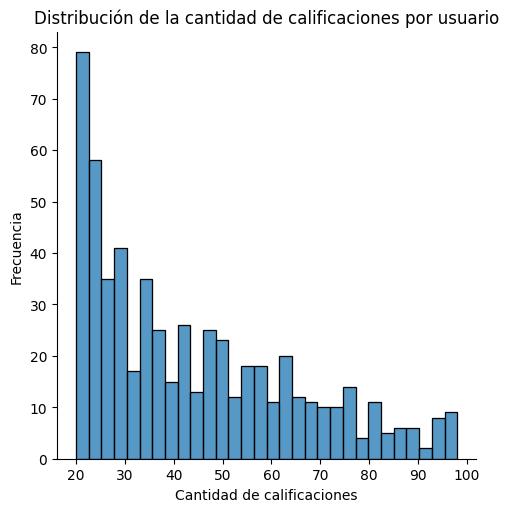

In [ ]:
plt.figure(figsize=(10, 6))
# Elegimos visualizar solamente aquellos conteos de usuarios con menos de 100 ratings publicados
filtered_ratings = user_counts[user_counts["rating"] < 100]
sns.displot(filtered_ratings["rating"], bins=30)
plt.title("Distribución de la cantidad de calificaciones por usuario")
plt.xlabel("Cantidad de calificaciones")
plt.ylabel("Frecuencia")
plt.show()

Procedemos a analizar el impacto en el dataset si quisiéramos purgar aquellos usuarios que han escrito menos de 50 calificaciones

In [ ]:
# Limitamos la búsqueda a los usuarios con menos de 50 ratings
min_ratings = 50
filtered_ratings = user_counts[user_counts["rating"] < min_ratings]
percentage = filtered_ratings.shape[0] * 100 / user_counts.shape[0]
print('Los usuarios que han escrito menos de {0} reviews representan el {1:.2f}% de la cantidad total de usuarios'.format(min_ratings, percentage))

Los usuarios que han escrito menos de 50 reviews representan el 39.77% de la cantidad total de usuarios


In [ ]:
ratings_made_by_filtered_users = all_merge_data[all_merge_data["user_id"].isin(filtered_ratings.index)]
print(f'La cantidad de ratings es: {ratings_made_by_filtered_users.shape[0]}')
percentage = ratings_made_by_filtered_users.shape[0] * 100 / all_merge_data.shape[0]
print('Esto representa un {0:.2f}% de los ratings totales.'.format(percentage))

La cantidad de ratings es: 11529
Esto representa un 11.53% de los ratings totales.


Vemos que un porcentaje importante de la cantidad total de usuarios ha escrito menos de 50 ratings. Sin embargo, estas reviews representan solamente un 11.53% del dataset total, por lo que podría considerarse eliminarlas.

## Distribución de calificaciones de usuarios con la mayor cantidad

Hay algunos usuarios con una cantidad inusual de calificaciones. Los analizaremos individualmente para definir si hay outliers.

In [ ]:
# Obtenemos los 20 usuarios con mayor número de calificaciones
top_users = all_merge_data['user_id'].value_counts().head(20)
top_users

user_id
405    737
655    685
13     636
450    540
276    518
416    493
537    490
303    484
234    480
393    448
181    435
279    434
429    414
846    405
7      403
94     400
682    399
308    397
92     388
293    388
Name: count, dtype: int64

In [ ]:
filtered_ratings = all_merge_data[all_merge_data['user_id'].isin(top_users.index)]
filtered_ratings.shape

(9574, 31)

<Figure size 1000x600 with 0 Axes>

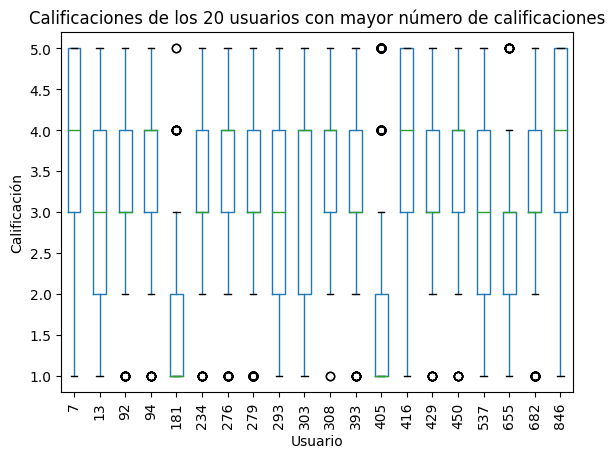

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html
plt.figure(figsize=(10, 6))
filtered_ratings.boxplot(column='rating', by='user_id', grid=False)
plt.title('Calificaciones de los 20 usuarios con mayor número de calificaciones')
plt.suptitle('')
plt.xlabel('Usuario')
plt.ylabel('Calificación')
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(f'La cantidad de ratings de los {top_users.shape[0]} usuarios con mayor cantidad de calificaciones es {filtered_ratings.shape[0]}')
percentage = filtered_ratings.shape[0] * 100 / all_merge_data.shape[0]
print('Esto representa un {:.2f}% del total de ratings'.format(percentage))

La cantidad de ratings de los 20 usuarios con mayor cantidad de calificaciones es 9574
Esto representa un 9.57% del total de ratings


Por último, nos interesa ver la relación entre la distribución de usuarios y el acumulado de cantidad de ratings

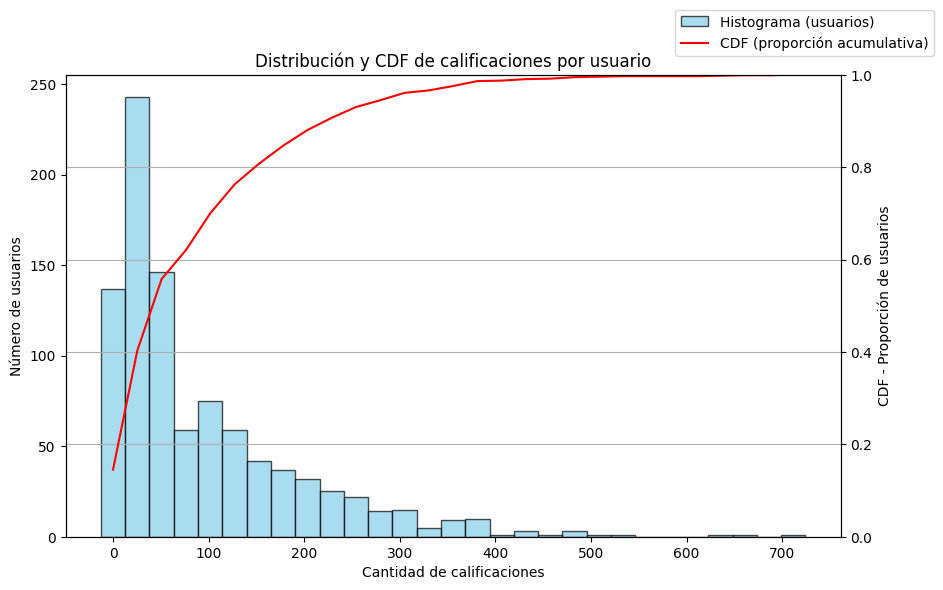

In [ ]:
user_counts = all_merge_data['user_id'].value_counts()

bins = np.linspace(0, user_counts.max(), 30)
hist, edges = np.histogram(user_counts, bins=bins)

# Calculamos la Función de Distribución Acumulativa (CDF)
cdf = hist.cumsum()
cdf = cdf / cdf.max() # Normalizar para que el CDF vaya de 0 a 1

fig, ax1 = plt.subplots(figsize=(10, 6))

# El eje de la izquierda va a ser los valores del histograma
ax1.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', color='skyblue', alpha=0.7, label='Histograma (usuarios)')
ax1.set_xlabel('Cantidad de calificaciones')
ax1.set_ylabel('Número de usuarios')

# Y el eje de la derecha será el porcentaje de calificaciones para el CDF y el PDF
ax2 = ax1.twinx()
ax2.plot(edges[:-1], cdf, color='red', label='CDF (proporción acumulativa)')
ax2.set_ylabel('CDF - Proporción de usuarios')
ax2.set_ylim(0, 1)  # Asegura que el CDF vaya de 0 a 1

plt.title('Distribución y CDF de calificaciones por usuario')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

# Creación de arbol

Antes de crear un modelo de árbol de decisión para resolver un problema de predicción, es fundamental identificar si el problema es de clasificación o de regresión. Esta distinción inicial es crucial porque influye directamente en la elección del algoritmo adecuado y en la forma en que se evaluará el rendimiento del modelo, por lo tanto de acuerdo a naturaleza del problema a resolver es posible distinguir entre:

*   **Clasificación**: el objetivo es predecir una etiqueta de clase discreta. Los datos de salida (etiquetas) pertenecen a categorías específicas y mutualmente exclusivas.
*   **Regresión**: el objetivo es predecir un valor continuo. Los datos de salida (etiquetas) son números reales y pueden asumir cualquier valor dentro de un rango.

In [ ]:
# Verificar los valores únicos en la columna 'rating'
unique_ratings = udata['rating'].unique()
print("Valores únicos de 'rating':", unique_ratings)

Valores únicos de 'rating': [3 1 2 4 5]


Al realizar la exploración de los valores únicos de rating se observa que estos son valores discretos y limitados, debido a ello es apropiado que se trate el problema como uno de clasificación mediante un DecisionTreeClassifier, lo cual a su vez determina las métricas de evaluación con las cuales se medirá el desempeño del modelo.

In [ ]:
# Vamos a usar solo el 80% de nuestro dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Resultados

In [ ]:
# Creando el arbol sin podar con el mismo random state
clf_unpruned = DecisionTreeClassifier(random_state=1)
clf_unpruned.fit(X_train, y_train)
y_pred_unpruned = clf_unpruned.predict(X_test)
print(classification_report(y_test, y_pred_unpruned))

              precision    recall  f1-score   support

           1       0.25      0.26      0.25      1209
           2       0.19      0.19      0.19      2267
           3       0.32      0.33      0.33      5324
           4       0.39      0.39      0.39      6897
           5       0.37      0.36      0.36      4303

    accuracy                           0.34     20000
   macro avg       0.30      0.31      0.30     20000
weighted avg       0.34      0.34      0.34     20000



In [ ]:
# Visualizar el arbol
plt.figure(figsize=(20,10))
#tree.plot_tree(clf_unpruned, filled=True, feature_names=feature_list)
plt.show()

<Figure size 2000x1000 with 0 Axes>

Matríz de confusión

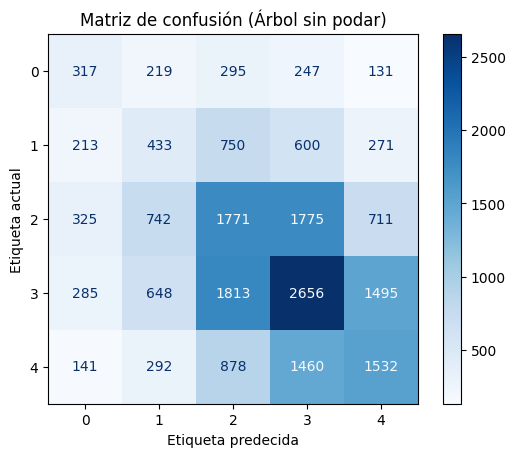

In [ ]:
conf_matrix_unpruned = confusion_matrix(y_test, y_pred_unpruned)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_unpruned)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusión (Árbol sin podar)')
plt.xlabel('Etiqueta predecida')
plt.ylabel('Etiqueta actual')
plt.show()

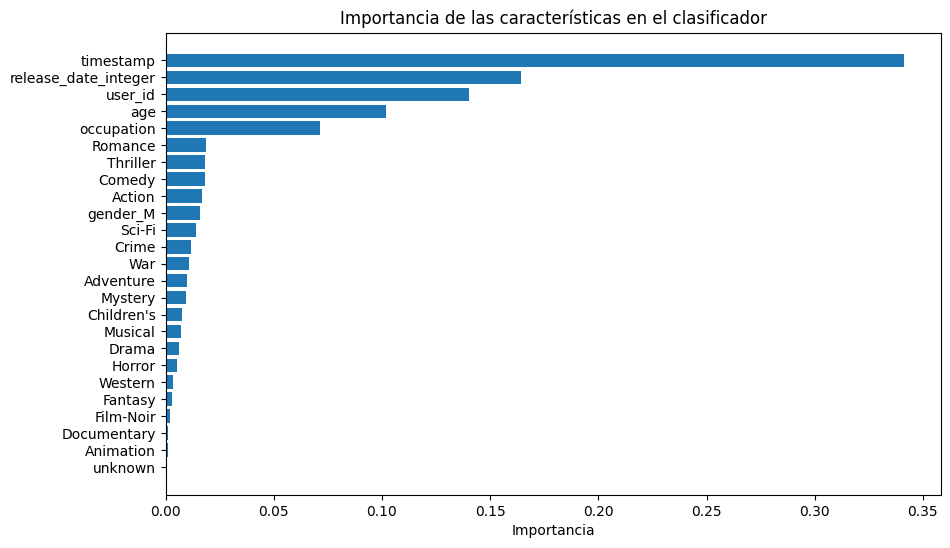

                 Feature  Importance
1              timestamp    0.341139
23  release_date_integer    0.164364
0                user_id    0.140227
2                    age    0.101646
3             occupation    0.071592
18               Romance    0.018822
20              Thriller    0.018391
9                 Comedy    0.018042
5                 Action    0.016800
24              gender_M    0.015990
19                Sci-Fi    0.014054
10                 Crime    0.011800
21                   War    0.010646
6              Adventure    0.010078
17               Mystery    0.009559
8             Children's    0.007616
16               Musical    0.007190
12                 Drama    0.006168
15                Horror    0.005076
22               Western    0.003495
13               Fantasy    0.002757
14             Film-Noir    0.001940
11           Documentary    0.001292
7              Animation    0.001275
4                unknown    0.000040


In [ ]:
# Obtener la importancia de las características
feature_importances = clf_unpruned.feature_importances_
feature_names = feature_list

# Crear un DF
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar los features
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(feature_names)), importance_df['Importance'], align='center')
plt.yticks(np.arange(len(feature_names)), importance_df['Feature'])
plt.xlabel('Importancia')
plt.title('Importancia de las características en el clasificador')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

# Print feature importances
print(importance_df)

Visualizamos las metricas por usuario

In [ ]:
# def para imprimir clasificacion por una lista de usuarios
def print_classification_report(users_list, X_test, y_test, model_to_test):
    for user_id in users_list:
        # Filtra X_test y y_test para el user_id actual
        X_test_filtrado = X_test[X_test['user_id'] == user_id]
        y_test_filtrado = y_test.loc[X_test_filtrado.index]

        # Predice con el clasificador
        y_pred_unpruned_tuned_filtrado = model_to_test.predict(X_test_filtrado)

        # Imprime el reporte de clasificación
        print(f"Clasificación para user_id: {user_id}")
        print(classification_report(y_test_filtrado, y_pred_unpruned_tuned_filtrado))

In [ ]:
# Contar la frecuencia de cada user_id en X_test
user_frequencies = X_test['user_id'].value_counts()

# Obtener los 5 user_id con más apariciones
top_5_users = user_frequencies.index[:5]

# Llamar a la función para imprimir los reportes de clasificación
print_classification_report(top_5_users, X_test, y_test, clf_unpruned)

Clasificación para user_id: 405
              precision    recall  f1-score   support

           1       0.72      0.62      0.67       105
           2       0.00      0.00      0.00        11
           3       0.06      0.09      0.07        11
           4       0.24      0.36      0.29        11
           5       0.40      0.24      0.30        17

    accuracy                           0.48       155
   macro avg       0.28      0.26      0.26       155
weighted avg       0.55      0.48      0.51       155

Clasificación para user_id: 13
              precision    recall  f1-score   support

           1       0.38      0.45      0.41        29
           2       0.19      0.12      0.14        26
           3       0.24      0.30      0.27        33
           4       0.20      0.23      0.21        22
           5       0.46      0.37      0.41        30

    accuracy                           0.30       140
   macro avg       0.29      0.29      0.29       140
weighted avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Ajustes en los datos

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

### Codificación y eliminación de variables.

Un detalle importante que se puede observar a partir del gráfico anterior es el gran peso que están tomando los valores de timestamp para influenciar los procesos de toma de decisiones en el árbol. Sin embargo, el momento en específico en que un usuario realiza una crítica es un dato que difícilmente tiene relación directa a la calificación asignada, por lo que su inclusión puede estar agregando ruido al modelo y es recomendable excluirlo.

Con respecto al user_id es un caso que debe ser manejado con más cuidado pues a pesar de ser un dato que también tiene poco valor categórico, su inclusión podría aportar información que codifique un perfil de usuario. Para ello se reemplaza los identificadores de usuario con la media del rating para cada usuario en una nueva columna user_id_encoded.

In [ ]:
# Calcular la calificación media por usuario
#user_mean_rating = all_merge_data.groupby('user_id')['rating'].mean()

# Mapear la calificación media al user_id en los datos originales
#all_merge_data['user_id_encoded'] = all_merge_data['user_id'].map(user_mean_rating)

# Lista de características
#feature_list = all_merge_data.drop(columns=['rating','movie_id', 'zip code', 'movie_title', 'IMDb_URL'], axis=1).columns
feature_list = all_merge_data.drop(columns=['rating','movie_id', 'item_id', 'zip code', 'movie_title', 'IMDb_URL'], axis=1).columns

# creamos el vector X y y para la creacion del arbol, algunas columnas no se ocuparan como el zip code, la ocupacion o el IMDb_URL

X = pd.get_dummies(all_merge_data[feature_list])

# nuestra columna objetivo es el de rating
y = all_merge_data.rating

# Vamos a usar solo el 80% de nuestro dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Creando el árbol sin podar con el mismo estado aleatorio
clf_unpruned = DecisionTreeClassifier(random_state=1)
clf_unpruned.fit(X_train, y_train)
y_pred_unpruned = clf_unpruned.predict(X_test)
print(classification_report(y_test, y_pred_unpruned))

              precision    recall  f1-score   support

           1       0.25      0.26      0.25      1209
           2       0.19      0.19      0.19      2267
           3       0.32      0.33      0.33      5324
           4       0.39      0.39      0.39      6897
           5       0.37      0.36      0.36      4303

    accuracy                           0.34     20000
   macro avg       0.30      0.31      0.30     20000
weighted avg       0.34      0.34      0.34     20000



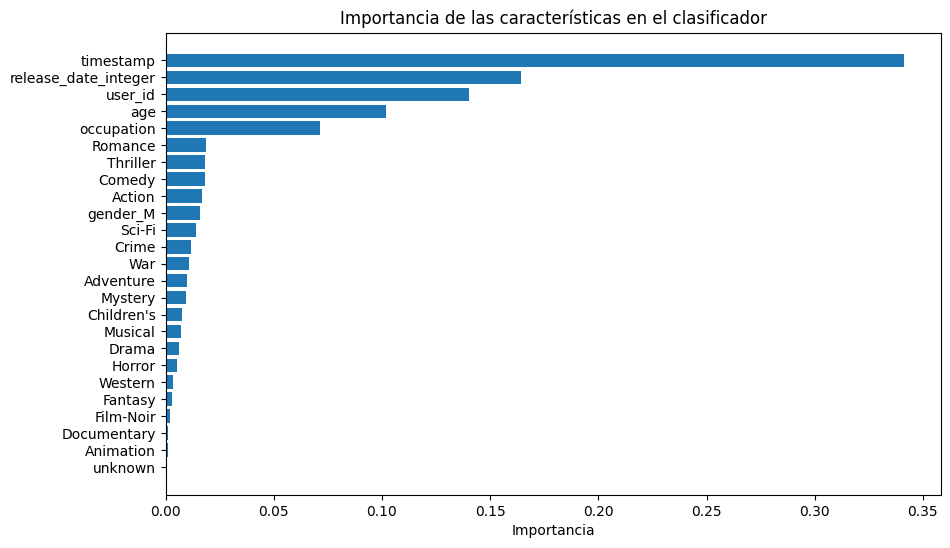

                 Feature  Importance
1              timestamp    0.341139
23  release_date_integer    0.164364
0                user_id    0.140227
2                    age    0.101646
3             occupation    0.071592
18               Romance    0.018822
20              Thriller    0.018391
9                 Comedy    0.018042
5                 Action    0.016800
24              gender_M    0.015990
19                Sci-Fi    0.014054
10                 Crime    0.011800
21                   War    0.010646
6              Adventure    0.010078
17               Mystery    0.009559
8             Children's    0.007616
16               Musical    0.007190
12                 Drama    0.006168
15                Horror    0.005076
22               Western    0.003495
13               Fantasy    0.002757
14             Film-Noir    0.001940
11           Documentary    0.001292
7              Animation    0.001275
4                unknown    0.000040


In [ ]:
# Obtener la importancia de las características
feature_importances = clf_unpruned.feature_importances_
feature_names = feature_list

# Crear un DF
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar los features
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(feature_names)), importance_df['Importance'], align='center')
plt.yticks(np.arange(len(feature_names)), importance_df['Feature'])
plt.xlabel('Importancia')
plt.title('Importancia de las características en el clasificador')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

# Print feature importances
print(importance_df)

### Componentes principales

Utilizaremos el método del codo para determinar el número óptimo de componentes principales (PCA) a utilizar en la reducción de dimensionalidad. El análisis de componentes principales (PCA) es una técnica que permite reducir el número de características en un conjunto de datos, conservando la mayor cantidad posible de variabilidad original. El método del codo nos ayuda a identificar el punto a partir del cual agregar más componentes principales no contribuye significativamente a la explicación de la variabilidad en los datos. Este paso es crucial para simplificar el modelo y mejorar su rendimiento sin perder información relevante.

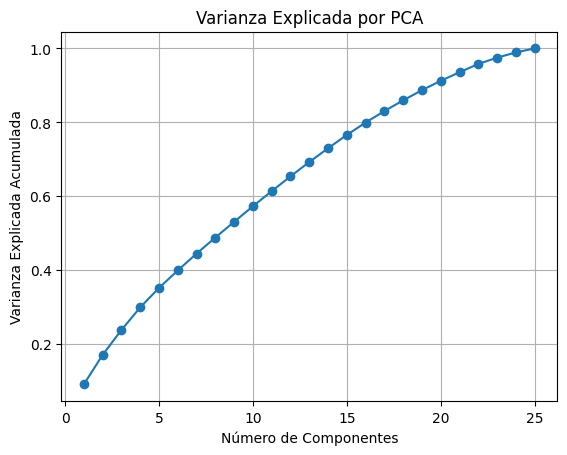

Optimal number of PCA components: 25


In [ ]:
#Antes de obtener las caracteristicas principales escalemos las variables

#El escalado de características ayuda a garantizar que todas las características contribuyan de manera equitativa al modelo

# Escalar las características y asignar los valores a una nueva variable
scaler = StandardScaler()

# Escalar las características de entrenamiento y prueba
scaled_train_features = scaler.fit_transform(X_train)
scaled_test_features = scaler.transform(X_test)

# Encontrar el número óptimo de componentes PCA utilizando el método del codo
pca = PCA()
pca.fit(scaled_train_features)

# Calcular la varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
# Calcular la varianza explicada acumulada
cumulative_explained_variance = np.cumsum(explained_variance)

# Graficar la varianza explicada
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA')
plt.grid()
plt.show()

# Determinar el número óptimo de componentes (punto del codo)
optimal_num_components = np.where(cumulative_explained_variance >= 0.99999)[0][0] + 1

print(f"Optimal number of PCA components: {optimal_num_components}")

In [ ]:
# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Ajustar un clasificador de árbol de decisión en el conjunto de datos transformado por PCA
pca_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', max_features='log2')
pca_tree.fit(X_train_pca, y_train)

# Realizar predicciones en el conjunto de datos transformado por PCA
pca_predictions = pca_tree.predict(X_test_pca)

print(classification_report(y_test, pca_predictions))

              precision    recall  f1-score   support

           1       0.20      0.21      0.21      1209
           2       0.17      0.18      0.18      2267
           3       0.30      0.31      0.30      5324
           4       0.37      0.37      0.37      6897
           5       0.32      0.31      0.32      4303

    accuracy                           0.31     20000
   macro avg       0.27      0.28      0.27     20000
weighted avg       0.31      0.31      0.31     20000



### Eliminación de características cuasi-constantes

Se realizar un escalado adicional para encontrar cuasi-constantes de un conjunto de datos

In [ ]:
# Se inicializa un objeto scaler2 y se ajusta (fit) a las dos primeras características del conjunto de entrenamiento
scaler2 = MinMaxScaler().fit(X_train.iloc[:,:2])

# Se escalan las dos primeras características de los conjuntos de entrenamiento y prueba utilizando el objeto scaler2
# Las características de entrenamiento se transforman y se actualizan en X_train
X_train.iloc[:,:2] = scaler2.transform(X_train.iloc[:,:2])

# Las características de prueba se transforman y se actualizan en X_test
X_test.iloc[:,:2] = scaler2.transform(X_test.iloc[:,:2])

El siguiente código elimina características cuasi-constantes de un conjunto de datos. Las características cuasi-constantes son aquellas con poca variabilidad, lo que puede interferir con los modelos de aprendizaje automático. Se utiliza VarianceThreshold de scikit-learn con un umbral de 0.01 para identificar estas características, y luego se cuentan las características restantes

In [ ]:
# Remover características cuasi-constantes
# Un umbral de 0.1 indica aproximadamente el 99% de las observaciones
sel = VarianceThreshold(
    threshold=0.01)

# El método fit encuentra las características con baja varianza
sel.fit(X_train)

# ¿Cuántas características no son cuasi-constantes?
sum(sel.get_support())

# caracteristicas finales
features_to_keep = X_train.columns[sel.get_support()]

# Características removidas
features_to_remove = X_train.columns[~sel.get_support()]

# Podemos entonces eliminar las características con las siguientes transformaciones
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

# Se imprime la forma de los nuevos conjuntos de datos para verificar el efecto de la eliminación de características
X_train.shape, X_test.shape

# Imprimir características finales y removidas
print("\nCaracterísticas finales:")
print(features_to_keep)
print("\nCaracterísticas removidas:")
print(features_to_remove)



Características finales:
Index(['user_id', 'timestamp', 'age', 'occupation', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'release_date_integer', 'gender_M'],
      dtype='object')

Características removidas:
Index(['unknown', 'Documentary'], dtype='object')


In [ ]:
# Las transformaciones de sklearn conducen a matrices numpy
# aquí transformo las matrices de vuelta a dataframes
# tenga en cuenta de asignar correctamente las columnas

X_train= pd.DataFrame(X_train)  # Convierto la matriz X_train en un DataFrame de pandas
X_train.columns = features_to_keep  # Asigno los nombres de las características conservadas a las columnas de X_train

X_test= pd.DataFrame(X_test)  # Convierto la matriz X_test en un DataFrame de pandas
X_test.columns = features_to_keep  # Asigno los nombres de las características conservadas a las columnas de X_test

# Verificar características duplicadas en el conjunto de entrenamiento
duplicated_feat = []  # Lista para almacenar características duplicadas
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # Esto me ayuda a entender cómo avanza el bucle
        print("Progreso del bucle:", i)

    col_1 = X_train.columns[i]  # Selecciona la columna actual

    # Compara con las columnas restantes
    for col_2 in X_train.columns[i + 1:]:
        # Si las columnas son iguales, se consideran duplicadas
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)  # Agrega la columna duplicada a la lista

# Imprimo la cantidad de características duplicadas encontradas
print("Cantidad de características duplicadas encontradas:", len(duplicated_feat))

Progreso del bucle: 0
Progreso del bucle: 10
Progreso del bucle: 20
Cantidad de características duplicadas encontradas: 0


In [ ]:
# Finalmente se remueve los caracteristicas duplicadas
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((80000, 23), (20000, 23))

In [ ]:
# Creando el arbol sin podar con el mismo random state y obteniendo los valores de f1
clf_unpruned_tuned = DecisionTreeClassifier()
clf_unpruned_tuned.fit(X_train, y_train)

# predicción
y_pred_unpruned_tuned = clf_unpruned_tuned.predict(X_test)

# resultado final
print(classification_report(y_test, y_pred_unpruned_tuned))

              precision    recall  f1-score   support

           1       0.24      0.26      0.25      1209
           2       0.18      0.18      0.18      2267
           3       0.32      0.34      0.33      5324
           4       0.39      0.38      0.39      6897
           5       0.36      0.35      0.36      4303

    accuracy                           0.33     20000
   macro avg       0.30      0.30      0.30     20000
weighted avg       0.33      0.33      0.33     20000



### Removiendo usuarios con menos reviews

Para finalizar removemos los usuarios que tienen menos de 50 reviews

In [ ]:
# Contar la cantidad de registros por usuario
user_counts = all_merge_data['user_id'].value_counts()

# Filtrar los usuarios que tienen 50 o más registros
users_to_keep = user_counts[user_counts >= 50].index
filtered_df = all_merge_data[all_merge_data['user_id'].isin(users_to_keep)]

#X = all_merge_data.drop(columns=['rating','timestamp', 'item_id','movie_title','zip code','IMDb_URL'], axis=1)
X = pd.get_dummies(filtered_df[feature_list])

# nuestra columna objetivo es el de rating
y = filtered_df.rating

# Vamos a usar solo el 80% de nuestro dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Creando el arbol sin podar con el mismo random state
clf_unpruned_tuned = DecisionTreeClassifier()
clf_unpruned_tuned.fit(X_train, y_train)
y_pred_unpruned_tuned = clf_unpruned_tuned.predict(X_test)
print(classification_report(y_test, y_pred_unpruned_tuned))

              precision    recall  f1-score   support

           1       0.27      0.29      0.28      1018
           2       0.21      0.21      0.21      2074
           3       0.35      0.35      0.35      4917
           4       0.40      0.39      0.39      6014
           5       0.37      0.37      0.37      3672

    accuracy                           0.35     17695
   macro avg       0.32      0.32      0.32     17695
weighted avg       0.35      0.35      0.35     17695



## Ajustes en hiperparametros


En esta sección, ajustaremos los hiperparámetros del clasificador de árbol de decisión utilizando una búsqueda en cuadrícula (GridSearchCV). Este proceso implica probar varias combinaciones de hiperparámetros y seleccionar la combinación que produce el mejor rendimiento basado en validación cruzada. Esto nos permite optimizar el modelo para obtener el mejor desempeño posible en términos de precisión.

In [ ]:
# poner en true para no hacer el grid search
skip_search = True # @param {type:"boolean"}
if not skip_search:

  # Definir la cuadrícula de parámetros para ajustar los hiperparámetros
  param_grid = {
      'max_features': ['sqrt', 'log2', None],
      'criterion' :['gini', 'entropy'],
      'splitter': ['best', 'random'],
      'max_depth': [2, 6, 10, 20],
      'min_samples_split': [2, 3, 5, 10],
      'min_samples_leaf': [1, 2, 4, 8],
      'ccp_alpha': [0.1, .01, .001, 0.0],
  }
  # Inicializar un clasificador de árbol de decisión
  dtree_class = DecisionTreeClassifier(random_state=1)

  # Realizar la búsqueda en cuadrícula con validación cruzada
  grid_search = GridSearchCV(estimator=dtree_class, param_grid=param_grid,
                            cv=5, n_jobs=-1, verbose=2)

  # Ajustar el modelo a los datos de entrenamiento
  grid_search.fit(X_train, y_train)

  # Obtener el mejor estimador de la búsqueda en cuadrícula
  best_dtree_class = grid_search.best_estimator_

  # Obtener los mejores parámetros encontrados en la búsqueda en cuadrícula
  best_params = grid_search.best_params_
  print(f"Best parameters: {best_params}")

  # Opcional: Hacer predicciones en los datos de prueba y calcular el error cuadrático medio (MSE) y la raíz del MSE (RMSE)
  # y_pred = best_dtree_class.predict(X_test)
  # mse = mean_squared_error(y_test, y_pred)
  # rmse = mse ** 0.5
  # print(f"Test RMSE: {rmse}")

Resultado del grid search
```
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits
Best parameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
```

In [ ]:
# Creando el arbol sin podar con el mismo random state
#clf_unpruned = DecisionTreeClassifier(random_state=1,criterion='gini',splitter = 'random')
clf_unpruned_tuned_2 = DecisionTreeClassifier(random_state=1, criterion='entropy', max_depth = 10, max_features= None, min_samples_leaf= 1, min_samples_split = 3, ccp_alpha = 0.0,splitter='best')
clf_unpruned_tuned_2.fit(X_train, y_train)
y_pred_unpruned_2 = clf_unpruned_tuned_2.predict(X_test)
print(classification_report(y_test, y_pred_unpruned_2))

              precision    recall  f1-score   support

           1       0.43      0.13      0.20      1018
           2       0.25      0.02      0.04      2074
           3       0.35      0.39      0.37      4917
           4       0.38      0.66      0.48      6014
           5       0.45      0.17      0.24      3672

    accuracy                           0.38     17695
   macro avg       0.37      0.27      0.27     17695
weighted avg       0.37      0.38      0.33     17695



Visualizamos las metricas por usuario

In [ ]:
# Contar la frecuencia de cada user_id en X_test
user_frequencies = X_test['user_id'].value_counts()

# Obtener los 5 user_id con más apariciones
top_5_users = user_frequencies.index[:5]

# Llamar a la función para imprimir los reportes de clasificación
print_classification_report(top_5_users, X_test, y_test, clf_unpruned_tuned_2)

Clasificación para user_id: 405
              precision    recall  f1-score   support

           1       0.66      0.66      0.66        95
           2       0.00      0.00      0.00        19
           3       0.07      0.14      0.10        14
           4       0.06      0.25      0.09         4
           5       0.29      0.11      0.16        18

    accuracy                           0.45       150
   macro avg       0.21      0.23      0.20       150
weighted avg       0.46      0.45      0.45       150

Clasificación para user_id: 13
              precision    recall  f1-score   support

           1       0.50      0.21      0.30        28
           2       0.00      0.00      0.00        19
           3       0.30      0.31      0.31        35
           4       0.28      0.70      0.40        30
           5       0.50      0.17      0.26        23

    accuracy                           0.31       135
   macro avg       0.31      0.28      0.25       135
weighted avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# Comparacion con otros metodos

## Métodos con Árboles

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

Definimos X y y nuevamente

In [ ]:
# lista de features
feature_list = all_merge_data.drop(columns=['rating','movie_id', 'item_id','movie_title','zip code','IMDb_URL'], axis=1).columns


# creamos el vector X y y para la creacion del arbol, algunas columnas no se ocuparan como el zip code, la ocupacion o el IMDb_URL
#X = all_merge_data.drop(columns=['rating','timestamp', 'item_id','movie_title','zip code','IMDb_URL'], axis=1)
X = pd.get_dummies(all_merge_data[feature_list])
# nuestra columna objetivo es el de rating
y = all_merge_data.rating

# Vamos a usar solo el 80% de nuestro dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# poner en true para no hacer el grid search
skip_search_1 = True # @param {type:"boolean"}
if not skip_search_1:

  param_grid = {
      'n_estimators': [50, 100, 200, 300, 500],
      'max_features': ['sqrt', 'log2', None],
      'criterion' :['gini', 'entropy']
  }

  grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid, cv= 5, n_jobs=-1, verbose=2)
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print(f"Best parameters: {best_params}")

Resultado del grid search
```
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 200}

```

In [ ]:
# fit model on training data
model_rfc = RandomForestClassifier(random_state=1, n_estimators=200, criterion='gini', max_features=None,)
model_rfc.fit(X_train, y_train)
# make predictions for test data
y_pred = model_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.39      0.27      0.32      1209
           2       0.25      0.16      0.19      2267
           3       0.36      0.39      0.37      5324
           4       0.42      0.49      0.45      6897
           5       0.44      0.41      0.43      4303

    accuracy                           0.39     20000
   macro avg       0.37      0.34      0.35     20000
weighted avg       0.39      0.39      0.39     20000



In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [ ]:
# poner en true para no hacer el grid search
skip_search_2 = True # @param {type:"boolean"}
if not skip_search_2:
  colsample_bytree = [0.3, 0.5, 1.0]
  learning_rate = [0.001, 0.01, 0.05]
  subsample = [0.8, 0.9, 1.0]
  n_estimators = [50, 100, 150]

  # Define the parameter grid to tune the hyperparameters
  param_grid = dict(
      colsample_bytree=colsample_bytree,
      learning_rate=learning_rate,
      subsample=subsample,
      n_estimators=n_estimators,
  )

  xgb_class = XGBClassifier(random_state=1) # Initialize a xgboost classifier
  grid_search = GridSearchCV(estimator=xgb_class, param_grid=param_grid,
                            cv=5, n_jobs=-1, verbose=2)
  grid_search.fit(X_train, y_train)
  best_dtree_class = grid_search.best_estimator_ # Get the best estimator from the grid search
  # y_pred = best_dtree_class.predict(X_test)
  # mse = mean_squared_error(y_test, y_pred)
  # rmse = mse ** 0.5
  best_params = grid_search.best_params_
  print(f"Best parameters: {best_params}")
  # print(f"Test RMSE: {rmse}")

In [ ]:
# fit model on training data
model_xgb = XGBClassifier(random_state=1, n_estimators=150, subsample=0.8, learning_rate=0.05,colsample_bytree=1.0)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# make predictions for test data
y_pred = model_xgb.predict(X_test)
y_pred = le.inverse_transform(y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.59      0.19      0.29      1209
           2       0.47      0.02      0.04      2267
           3       0.37      0.34      0.36      5324
           4       0.40      0.74      0.52      6897
           5       0.53      0.23      0.33      4303

    accuracy                           0.41     20000
   macro avg       0.47      0.30      0.31     20000
weighted avg       0.44      0.41      0.37     20000



## Comparación con otros métodos (no usando árboles)

Se procede a comparar las implementaciones de árboles decisión con K-Nearest Neighbors, Support Vector Machines y Multilayer perceptron

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [ ]:
feature_list = all_merge_data.drop(columns=['rating','movie_id', 'item_id','movie_title','zip code','IMDb_URL'], axis=1).columns

X = pd.get_dummies(all_merge_data[feature_list])
# nuestra columna objetivo es el de rating
y = all_merge_data.rating

# Vamos a usar solo el 80% de nuestro dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
#def print_metrics(y_test, y_pred, model_name):
#    print(f'{model_name} Accuracy: {accuracy_score(y_test, y_pred)}')
#    print(f'{model_name} Precision: {precision_score(y_test, y_pred, average="weighted")}')
#    print(f'{model_name} F1 Score: {f1_score(y_test, y_pred, average="weighted")}')

def print_metrics(y_true, y_pred, model_name):
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted', zero_division=1):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=1))

Al igual que con los Decision Trees, se hará un tuneo de hiperparámetros para cada uno

In [ ]:
 # poner en true para no hacer el grid search
skip_search_5 = True # @param {type:"boolean"}

if not skip_search_5:

  # Definir el pipeline para KNN
  pipe_knn = Pipeline(steps=[('std_slc', StandardScaler()),
                            ('pca', PCA()),
                            ('knn', KNeighborsClassifier())])

  # Definir el rango de hiperparámetros para KNN
  knn_params = {
      'pca__n_components': [1, 2, 6, 17, 23],
      'knn__n_neighbors': [3, 5, 7, 9, 11],
      'knn__weights': ['uniform', 'distance'],
      'knn__metric': ['euclidean', 'manhattan', 'minkowski']
  }

  # Crear GridSearchCV para KNN
  grid_search_knn = GridSearchCV(estimator=pipe_knn, param_grid=knn_params, cv=5, n_jobs=-1, verbose=2)
  grid_search_knn.fit(X_train, y_train)

  print("Mejores hiperparámetros para KNN:", grid_search_knn.best_params_)

Resultado del search:
```
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Mejores hiperparámetros para KNN: {'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'pca__n_components': 23}
```

In [ ]:
# poner en true para no hacer el grid search
skip_search_6 = True # @param {type:"boolean"}

if not skip_search_6:
  # Definir el pipeline para SVC
  pipe_svc = Pipeline(steps=[('std_slc', StandardScaler()),
                            ('pca', PCA(n_components=23)),
                            ('svc', SVC(max_iter=2000))])

  # Definir el rango de hiperparámetros para SVC
  svc_params = {
      'svc__C': [0.1, 1, 10],
      'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
  }

  # Crear GridSearchCV para SVC
  cv = StratifiedKFold(n_splits=2)
  grid_search_svc = GridSearchCV(estimator=pipe_svc, param_grid=svc_params, cv=cv, n_jobs=-1, verbose=2)
  grid_search_svc.fit(X_train, y_train)

  print("Mejores hiperparámetros para SVC:", grid_search_svc.best_params_)

resultados:
```
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Mejores hiperparámetros para SVC: {'svc__C': 0.1, 'svc__kernel': 'rbf'}
```

In [ ]:
# Poner en true para no hacer el random search
skip_search_7 = True # @param {type:"boolean"}

if not skip_search_7:
  # Definir el pipeline para MLP
  pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(max_iter=100))
  ])

  mlp_params = {
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__solver': ['adam', 'sgd'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'clf__max_iter': [100, 200, 300],
    'clf__batch_size': [16, 32, 64],
    'clf__early_stopping': [True, False],
    'clf__validation_fraction': [0.1, 0.2, 0.3]
  }

  # Dado al tamaño de la lista de parámetros, se utiliza random search
  random_search = RandomizedSearchCV(
      estimator = pipe_mlp,
      param_distributions = mlp_params,
      n_iter = 400,  # Cantidad de iteraciones a realizar la búsqueda
      cv = 3,
      scoring = 'accuracy',  # Métrica de salida
      verbose = 0,
      n_jobs = -1,
      random_state = 42
  )

  random_search.fit(X_train, y_train)

  print("Mejores hiperparámetros para MLP:", random_search.best_params_)

Por un tema de recursos computacionales, no fue posible ejecutar el algoritmo MLP en el colab, sin embargo, al ejecutarlo local se obtuvieron los siguientes resultados:

```
Mejores hiperparámetros para MLP: {'clf__validation_fraction': 0.3, 'clf__solver': 'adam', 'clf__max_iter': 300, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (100, 50), 'clf__early_stopping': False, 'clf__batch_size': 16, 'clf__alpha': 0.01, 'clf__activation': 'relu'}
```

In [ ]:
if (not skip_search_7) and (not skip_search_6) and (not skip_search_5):
  #crear los modelos con los parametros del paso anterior
  # Evaluar el rendimiento de KNN con los mejores hiperparámetros
  y_pred_knn_best = grid_search_knn.predict(X_test)

  # Evaluar el rendimiento de SVC con los mejores hiperparámetros
  y_pred_svc_best = grid_search_svc.predict(X_test)

  # Evaluar el rendimiento de MLP con los mejores hiperparámetros
  y_pred_mlp_best = random_search.predict(X_test)

else:
  # Crear el modelo KNN con los parámetros insertados manualmente basados en resultados anteriores
  knn_model = KNeighborsClassifier(
      metric='manhattan',
      n_neighbors=11,
      weights='distance'
  )

  # Crear el modelo SVC con los parámetros proporcionados
  svc_model = SVC(
      C=0.1,
      kernel='rbf'
  )

  # Crear el modelo MLP con los parámetros proporcionados
  mlp_model = MLPClassifier(
      validation_fraction=0.3,
      solver='adam',
      max_iter=300,
      learning_rate='constant',
      hidden_layer_sizes=(100, 50),
      early_stopping=False,
      batch_size=16,
      alpha=0.01,
      activation='relu'
  )

 # Escalar las características y asignar los valores a una nueva variable
  scaler = StandardScaler()

  # Escalar las características de entrenamiento y prueba
  scaled_train_features = scaler.fit_transform(X_train)
  scaled_test_features = scaler.transform(X_test)

  # Ajustar el modelo KNN a los datos de entrenamiento
  knn_model.fit(scaled_train_features, y_train)

  # Hacer predicciones en nuevos datos
  y_pred_knn_best = knn_model.predict(scaled_test_features)

  # Ajustar el modelo SVC a los datos de entrenamiento
  svc_model.fit(scaled_train_features, y_train)

  # Hacer predicciones en nuevos datos
  # Evaluar el rendimiento de SVC con los mejores hiperparámetros
  y_pred_svc_best = svc_model.predict(scaled_test_features)

  # Ajustar el modelo MLP a los datos de entrenamiento
  mlp_model.fit(scaled_train_features, y_train)

  # Evaluar el rendimiento de MLP con los mejores hiperparámetros
  y_pred_mlp_best = mlp_model.predict(scaled_test_features)

print_metrics(y_test, y_pred_knn_best, "KNN Tuned")
print_metrics(y_test, y_pred_svc_best, "SVC Tuned")
print_metrics(y_test, y_pred_mlp_best, "MLP Tuned")

Results for KNN Tuned:
Accuracy: 0.3510
Precision: 0.3446
F1 Score: 0.3460

Classification Report:
               precision    recall  f1-score   support

           1       0.32      0.24      0.27      1209
           2       0.21      0.14      0.17      2267
           3       0.33      0.35      0.34      5324
           4       0.39      0.44      0.41      6897
           5       0.38      0.35      0.36      4303

    accuracy                           0.35     20000
   macro avg       0.32      0.30      0.31     20000
weighted avg       0.34      0.35      0.35     20000

Results for SVC Tuned:
Accuracy: 0.3570
Precision: 0.4832
F1 Score: 0.2594

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.00      0.00      1209
           2       1.00      0.00      0.00      2267
           3       0.33      0.18      0.24      5324
           4       0.36      0.86      0.51      6897
           5       0.46      0.06      0

Así mismo, dada la duración de los algoritmos de optimización, no se tienen los datos en tiempo real, ya que estos fueron corridos de forma local, con los siguientes resultados:


```
KNN Tuned Accuracy: 0.3699
KNN Tuned Precision: 0.3686392406850771
KNN Tuned F1 Score: 0.36170031593743945
SVC Tuned Accuracy: 0.28505
SVC Tuned Precision: 0.30485438702115086
SVC Tuned F1 Score: 0.26978374422893775
MLP Tunned Accuracy: 0.37935
MLP Tunned Precision: 0.42138796522634914
MLP Tunned F1 Score: 0.32100601958928676
```



# Referencias

[1] F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872  
Archanakokate. (n.d.). Movielens Project.ipynb. GitHub. Retrieved from https://github.com/Archanakokate/Movielens-Case-Study-EDA-Prediction-/blob/main/Movielens%20Project.ipynb  

https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/  

https://www.kaggle.com/code/professionalhima/movielens-ml-models